In [1]:
from pathlib import Path
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import openvino as ov
import urllib.request

urllib.request.urlretrieve(url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py', filename='notebook_utils.py')

from notebook_utils import download_file

In [2]:
MODEL_DIR = Path("model")
MODEL_DIR.mkdir(exist_ok=True)
download_file("https://storage.googleapis.com/ailia-models/pointnet_pytorch/chair_100.onnx", directory=Path(MODEL_DIR), show_progress=False)
onnx_model_path = MODEL_DIR / "chair_100.onnx"

In [3]:
ir_model_xml = onnx_model_path.with_suffix(".xml")
core = ov.Core()

if not ir_model_xml.exists():
    model = ov.convert_model(onnx_model_path)
    ov.save_model(model, ir_model_xml)
else:
    model = core.read_model(model=ir_model_xml)
    

In [4]:
def load_data(point_file: Union[str, Path]):
    point_set = np.loadtxt(point_file).astype(np.float32)
    point_set = point_set - np.expand_dims(np.mean(point_set, axis=0), 0)
    dist = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)), 0)
    point_set = point_set / dist

    return point_set


def visualize(point_set:np.ndarray):
    fig = plt.figure(dpi=192, figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    X = point_set[:, 0]
    Y = point_set[:, 2]
    Z = point_set[:, 1]

    max_range = np.array([X.max() - X.min(), Y.max() - Y.min(), Z.max() - Z.min()]).max() * 0.5
    mid_x = (X.max() + X.min()) * 0.5
    mid_y = (Y.max() + Y.min()) * 0.5
    mid_z = (Z.max() + Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tick_params(labelsize=5)
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)

    return ax

data\chair.pts:   0%|          | 0.00/69.2k [00:00<?, ?B/s]

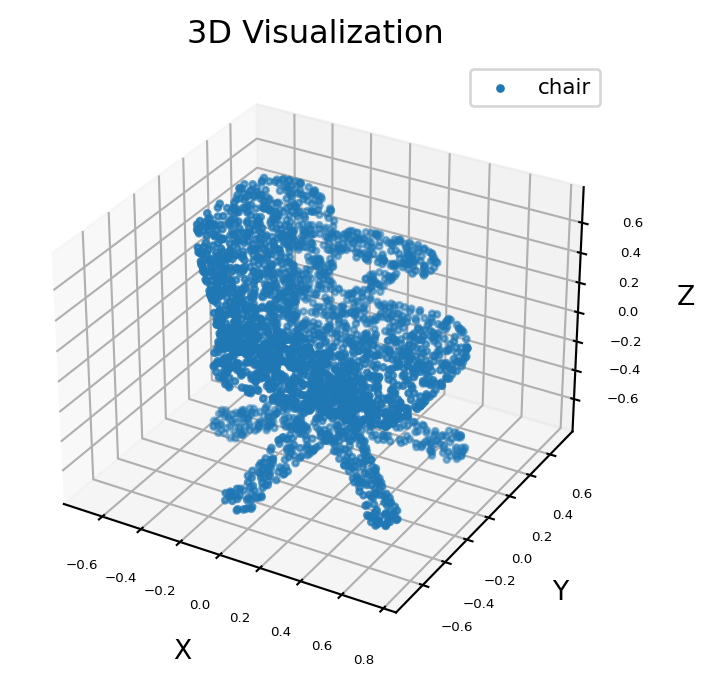

In [5]:
point_data = download_file("https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/pts/chair.pts", directory="data")
points = load_data(str(point_data))
X = points[:, 0]
Y = points[:, 2]
Z = points[:, 1]
ax = visualize(points)
ax.scatter3D(X, Y, Z, s=5, cmap="jet", marker="o", label='chair')
ax.set_title('3D Visualization')
plt.legend(loc='upper right', fontsize=8)
plt.show()

In [6]:
classes = ['back', 'seat', 'leg', 'arm']

point = points.transpose(1, 0)
point = np.expand_dims(point, axis=0)

print(f"input shape: {model.input(0).partial_shape}")
print(f"output shape: {model.output(0).partial_shape}")

input shape: [1,3,?]
output shape: [1,?,4]


In [7]:
import ipywidgets as widgets

device = widgets.Dropdown(options=core.available_devices + ["AUTO"], value='AUTO', description='Device:', disabled=False)
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

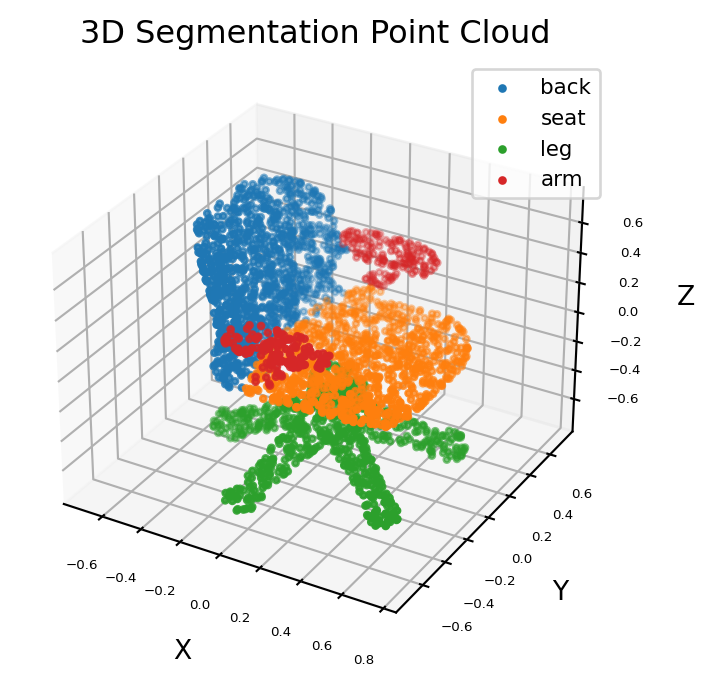

In [8]:
compiled_model = core.compile_model(model=model, device_name=device.value)
output_layer = compiled_model.output(0)
result = compiled_model([point])[output_layer]

pred = np.argmax(result[0], axis=1)
ax = visualize(point)
for i, name in enumerate([0, 1, 2, 3]):
    XCur = []
    YCur = []
    ZCur = []
    for j, nameCur in enumerate(pred):
        if name == nameCur:
            XCur.append(X[j])
            YCur.append(Y[j])
            ZCur.append(Z[j])
    XCur = np.array(XCur)
    YCur = np.array(YCur)
    ZCur = np.array(ZCur)

    ax.scatter(XCur, YCur, ZCur, s=5, cmap="jet", marker="o", label=classes[i])

ax.set_title('3D Segmentation Point Cloud')
plt.legend(loc='upper right', fontsize=8)
plt.show()